# Data Exploration, Data Cleansing, and Feature Extraction

In this notebook we will explore the [Sentiment140 dataset with 1.6 million tweets](https://www.kaggle.com/datasets/kazanova/sentiment140/code) and perform some data pre-processing and feature engineering.

**Problem statement:** determining a machine learning model that can determine if a tweet is offensive or not. This results in a binary classification problem where our classes will be offensive (positive) or non-offensive (negative).

The main focus for this notebook will be to understand our data and prepare it for data processing. Expect throughout this notebook several graphs and other visualization techniques to better understand characteristics of the data such as target class distribution and word frequency distribution.

Since we are dealing with text data we need to transform it into a dataset that can be understood by a model that handles numerical data. Our goal today is to determine the best way to transform the data to match the models' input as well as remove features and tokens (words) that could equate to noise. We want to introduce certain bias by focusing mainly on words that actually determine one of the target classes while still maintaining low variance on the validation set. This will be achieved by creating a balance from removing unnecesary features or feature data while still mantaining a good representation of real world scenarios. I will be performing the following steps for pre-processing and feature engineering:

- Noise Reduction (i.e. removal of twitter mentions and emojis, punctuation, stop words, URLs)
- Feature Engineering (i.e. tokenization, lemmatization, tf-idf vectorization)
- Dimmentionality Reduction (i.e. Truncated SVD transformation, filtering words with very high/very low frequencies).

Feel free to follow along this project by reading the code, comments, and outputs (tables, graphs) or by running the notebook's cells starting from the top. If you prefer, click on **Kernel -> Restart and Clear Output** to clear the cells' outputs to start from scratch.

### Library imports and Dataset downloads



In [53]:
# Data Manipulation and Numeric Libraries
import pandas as pd
import numpy as np

# Visualization Library
import matplotlib.pyplot as plt

# Text Preprocessing and Regular Expressions
import re, string, contractions, math

# Natural Language Processing (NLP) Libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

# Feature Extraction and Dimensionality Reduction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import decomposition

# Utilities and Data Structures
from collections import Counter
import ast

In [54]:
# NLTK Downloads - these are not imported but are necessary for downloading specific NLTK resources.
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt')

## The Data
The dataset contains features regarding the Tweet's text contents and some additonal features. We can see the following columns in the table down below.

- target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- ids: The id of the tweet ( 2087)
- date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- flag: The query (lyx). If there is no query, then this value is NO_QUERY.
- user: the user that tweeted (robotickilldozr)
- text: the text of the tweet (Lyx is cool)

In [63]:
DATASET_COLUMNS = ['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('tweets.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


## Initial Data Exploration

In [64]:
df['target'].unique()#, df.columns.tolist(), df.info()

array([0, 4])

In [ ]:
df['target'] = (df['target'] == 4).astype(int)

### Class balance - Too good to be true...

In [5]:
df_counts = df['target'].value_counts()
df_counts

target
0    800000
1    800000
Name: count, dtype: int64

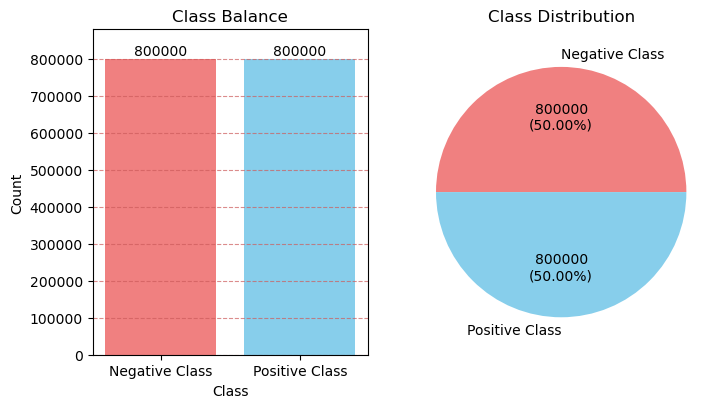

In [6]:
def auto_label(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height),
                    xytext=(0, 3),  # 3pt vertical offset
                    textcoords="offset points",
                    ha='center')
        
def simple_bar(counts, ax):
    index = np.arange(len(counts))
    bars = ax.bar(counts.index.astype(str), counts.values, color=['lightcoral','skyblue'])
    auto_label(bars, ax)
    ax.margins(0.05, 0.1)
    ax.set_title('Class Balance')
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.grid(axis='y', linestyle='--', alpha=0.7, color='indianred')
    ax.set_xticks(index)
    ax.set_xticklabels(['Negative Class', 'Positive Class'])

def simple_pie(counts, ax):
    ax.pie(counts, labels=['Negative Class', 'Positive Class'], colors = ['lightcoral', 'skyblue'],
           autopct=lambda p: '{:.0f}\n({:.2f}%)'.format(p * sum(counts) / 100, p))
    ax.axis('equal')
    ax.set_title('Class Distribution')

fig, axs = plt.subplots(1, 2, figsize=(8, 5))

simple_bar(df_counts, axs[0])
simple_pie(df_counts, axs[1])

plt.tight_layout(pad=4.0)
plt.show()

In [9]:
sample_size = 10000
data = df[['text', 'target']].sample(n=sample_size, random_state=43).reset_index(drop=True)

In [10]:
data_counts = data['target'].value_counts()
print(data_counts)
data

target
0    5005
1    4995
Name: count, dtype: int64


,text,target
0,@speakforme I know. We should go asap. like wh...,0
1,@pcdmelodyt hi melody @AshleyLTMSYF hi ashley...,1
2,Mount Larcom (finally,1
3,@Lisa_Nova we had it but we lost it very sad ...,0
4,@kneath I hate you so much right now,1
...,...,...
9995,@Youssef90 ....Y ??,0
9996,@7News - Post a complaint about the teacher at...,1
9997,@amorhilton http://twitpic.com/6v6ao - ill kee...,1
9998,@dancer__08 You need to come here,1


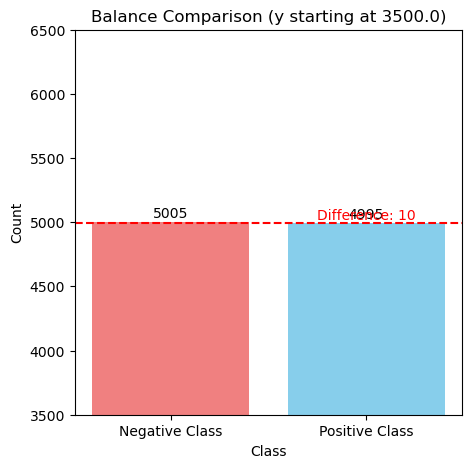

In [11]:
def floor_thousand(num):
    ceil = math.ceil((num - 1000) / 1000) * 1000
    return ceil

def bar_difference(counts, ax):
    bars = ax.bar(counts.index.astype(str), counts.values, color=['lightcoral', 'skyblue'])
    index = np.arange(len(counts))
    n = min(counts.values[0], counts.values[1])
    m = max(counts.values[0], counts.values[1])
    diff = m-n
    # Adjust the ylim to include some space above the max value to show the difference
    
    m_ceil = floor_thousand(m)+1000
    n_floor = floor_thousand(n)
    ceil_diff = m_ceil - n_floor
    
    ax.set_ylim(top=(m_ceil + ceil_diff / 4), bottom=(n_floor - ceil_diff / 4))
    auto_label(bars, ax)
    diff_annotation = f'Difference: {diff}'
    ax.text(1, n + diff / 2, diff_annotation, ha='center', va='bottom', fontsize=10, color='red')

    # Correct way to include dynamic content in the title

    ax.set_title(f"Balance Comparison (y starting at {n_floor - ceil_diff/4})")
    ax.set_ylabel('Count')
    ax.set_xlabel('Class')
    ax.set_xticks(index)
    ax.set_xticklabels(['Negative Class', 'Positive Class'])
    
    ax.axhline(y=min(n, m), color='red', linewidth=1.5, linestyle='--')
    
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
bar_difference(data_counts, axs)

plt.show()

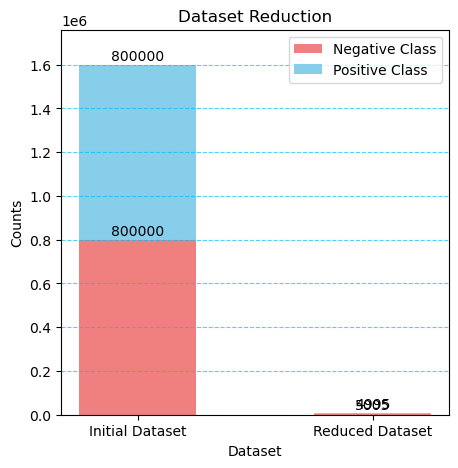

In [12]:
def compare_datasets(old_counts, new_counts, ax):
    index = np.arange(len(old_counts))
    bar_width = 0.5
    # Stacked bar for old counts
    bars1 = ax.bar([0,1], [old_counts[0], new_counts[0]], bar_width, label='Negative Class', color='lightcoral')

    # Stacked bar for new counts, on top of old counts
    bars2 = ax.bar([0,1], [old_counts[1], new_counts[1]], bar_width, bottom=[old_counts[0], new_counts[0]], label='Positive Class', color='skyblue')

    # Labeling
    ax.set_xlabel('Dataset')
    ax.set_ylabel('Counts')
    ax.set_title('Dataset Reduction')
    ax.set_xticks(index)
    ax.set_xticklabels(['Initial Dataset', 'Reduced Dataset'])
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7, color='deepskyblue')
    ax.margins(0.05, 0.1)

    auto_label(bars1, ax)
    auto_label(bars2, ax)
    
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

compare_datasets(df_counts,data_counts, axs)

plt.show()

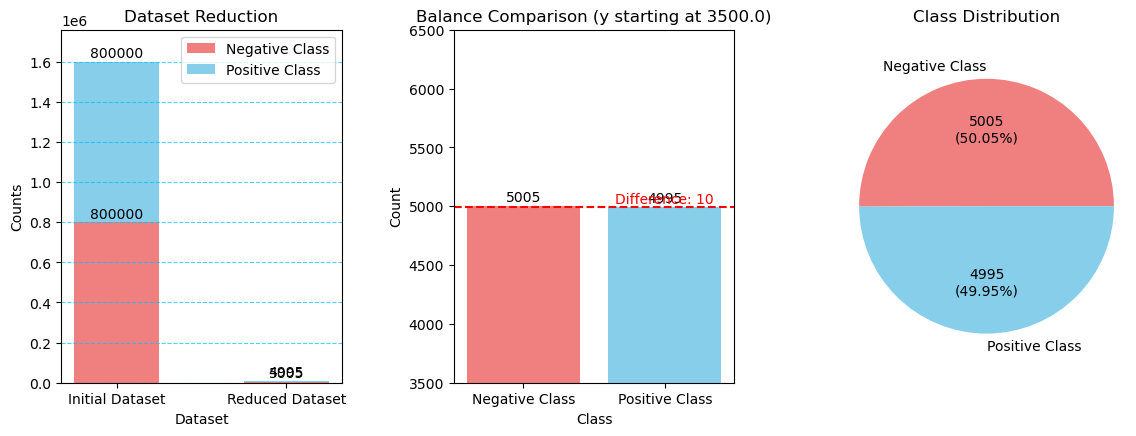

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

compare_datasets(df_counts,data_counts, axs[0])
bar_difference(data_counts, axs[1])
simple_pie(data_counts, axs[2])
plt.tight_layout(pad=3.0)

plt.show()

## Undersampling the Negative Class - Real World Scenario

In many real-world applications, datasets are inherently imbalanced. This means that the classes of interest are not equally represented. For instance, in fraud detection, fraudulent transactions are typically much less frequent than legitimate ones. This is also common in medical diagnosis, where the negative class (tumor cases) This imbalance poses a challenge for machine learning models, as they may become biased towards the majority class, resulting in poor performance on the minority class, which is often of greater interest.

To address these challenges and develop solutions that are robust in the face of class imbalance, it is crucial for data scientists and machine learning practitioners to understand how models perform under such conditions. By intentionally introducing class imbalance into our project's dataset, we aim to simulate real-world conditions more closely. This allows us to explore and evaluate strategies for handling imbalanced data, such as resampling techniques, cost-sensitive learning, or the use of specific evaluation metrics that are more informative for imbalanced datasets.

This approach not only enhances the realism of our project but also prepares us to tackle similar challenges in real-world applications. It underscores the importance of careful preprocessing, model selection, and evaluation strategies that account for class imbalance. Through this process, we seek to contribute insights and methodologies that are directly applicable to practical problems, ultimately leading to more effective and equitable machine learning solutions.

In [14]:


# Set the seed for random number generation


# Define the ranges for x and y
n = data['target'].value_counts()[1]  # Upper limit for class 0

# Generate random numbers x and y
np.random.seed(50)
n_x = np.random.randint(sample_size/8, n)

print(f"Number of entries to keep from Class 1: {n_x}")

reduced_data_class_1 = data[data['target']==1].sample(n=n_x, random_state=43)

reduced_data = pd.concat([data[data['target']==0], reduced_data_class_1], ignore_index=True)

print(f"Original data size: {len(data)}, Reduced data size: {len(reduced_data)}")
reduced_data

Number of entries to keep from Class 1: 2962
Original data size: 10000, Reduced data size: 7967


,text,target
0,@speakforme I know. We should go asap. like wh...,0
1,@Lisa_Nova we had it but we lost it very sad ...,0
2,I would've wifed @KiyastarW ... if only she wo...,0
3,@Kelsie_love Carita is down in San Antonio if...,0
4,@KylieD87 @25superstar I'm sorry... But I ha...,0
...,...,...
7962,"on the phone w/rosie and summer,",1
7963,@jawar I see so many things you write and so m...,1
7964,@BJpickleman I sympathize with her I have to ...,1
7965,A wonderful day with family and getting stuff ...,1


In [15]:
reduced_data_counts = reduced_data['target'].value_counts()
reduced_data_counts

target
0    5005
1    2962
Name: count, dtype: int64

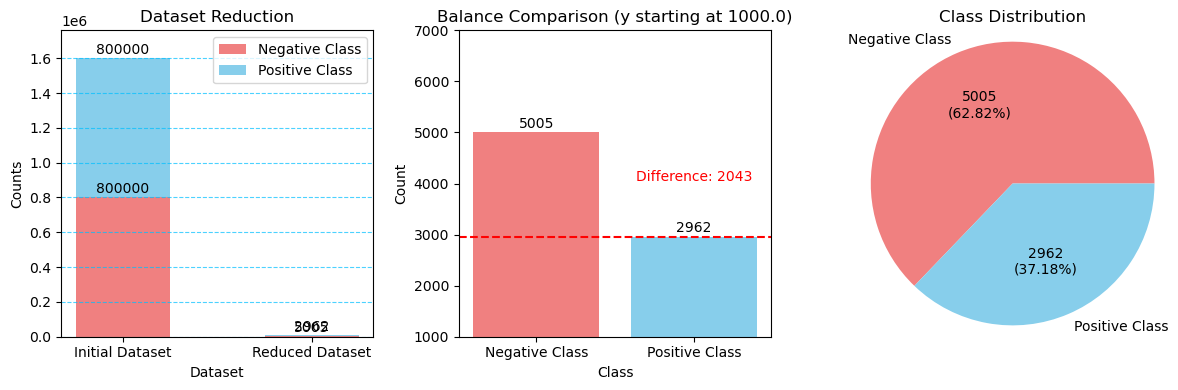

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

compare_datasets(df_counts, reduced_data_counts, axs[0])

bar_difference(reduced_data_counts, axs[1])
simple_pie(reduced_data_counts, axs[2])

plt.tight_layout()
plt.show()

## Data Pre-processing

### Noise removal and Tokenization

In [18]:


tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)

def preprocess_text(text):
    # Step 1: Expand contractions
    text = contractions.fix(text)
    
    # Step 2: Remove URLs starting with http or https
    text = re.sub(r'http[s]?://[^\s]+', '', text)
    
    # Step 3: Remove URLs with common top-level domains (TLDs)
    text = re.sub(r'(?:www\.)?[a-zA-Z0-9-]+\.(com|org|net|edu|gov|io)[^\s]*', '', text)
    
    # Step 4: Remove www. prefixes not covered by previous steps
    text = re.sub(r'www\.[a-zA-Z0-9-]+\.[^\s]+', '', text)
    
    # Step 5: Remove mentions
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    
    # Step 6: Remove all punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Step 6: Remove all punctuation
    text = re.sub(r'\d+', '', text)
    
    # Step 7: Remove non-ASCII characters
    text = ''.join(i for i in text if ord(i) < 128)
    
    # Step 8: Tokenize
    tokens = tokenizer.tokenize(text)
    
    return tokens

reduced_data['text'] = reduced_data['text'].apply(preprocess_text)

In [19]:
print(reduced_data['text'][0])
reduced_data

['I', 'know', 'We', 'should', 'go', 'as', 'soon', 'as', 'possible', 'like', 'when', 'we', 'get', 'back', 'home', 'I', 'want', 'to', 'buy', 'jeans', 'too', 'But', 'I', 'am', 'too', 'fat', 'for', 'jeans']


,text,target
0,"[I, know, We, should, go, as, soon, as, possib...",0
1,"[we, had, it, but, we, lost, it, very, sad, us...",0
2,"[I, would, have, wifed, if, only, she, would, ...",0
3,"[Carita, is, down, in, San, Antonio, if, you, ...",0
4,"[I, am, sorry, But, I, have, to, prepare, emot...",0
...,...,...
7962,"[on, the, phone, wrosie, and, summer]",1
7963,"[I, see, so, many, things, you, write, and, so...",1
7964,"[I, sympathize, with, her, I, have, to, straig...",1
7965,"[A, wonderful, day, with, family, and, getting...",1


### Lemmatization and Case Lowering

In [20]:
lemmatizer = WordNetLemmatizer()

def lemmatize_and_lower(tokens):
    cleaned_tokens = []
    for token, tag in pos_tag(tokens):
        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        token = lemmatizer.lemmatize(token,pos)
        if len(token) > 0 and token not in string.punctuation and token.lower() not in stopwords.words('english'):
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

reduced_data.loc[:,'text'] = reduced_data.loc[:,'text'].apply(lambda x: lemmatize_and_lower(x))

In [21]:
print(reduced_data['text'][0])

['know', 'go', 'soon', 'possible', 'like', 'get', 'back', 'home', 'want', 'buy', 'jean', 'fat', 'jean']


In [22]:
reduced_data.to_csv('tokenized.csv', index=False)

In [23]:
print(reduced_data['text'])

0       [know, go, soon, possible, like, get, back, ho...
1                                   [lose, sad, us, love]
2                                   [would, wifed, would]
3            [carita, san, antonio, need, someone, rough]
4       [sorry, prepare, emotionally, case, basket, ca...
                              ...                        
7962                              [phone, wrosie, summer]
7963     [see, many, thing, write, much, true, wise, man]
7964             [sympathize, straighten, hair, everyday]
7965    [wonderful, day, family, get, stuff, great, di...
7966                                     [jealous, blast]
Name: text, Length: 7967, dtype: object


## Feature Engineering

### Tf-Idf Vectorization

In [25]:
tokenized = pd.read_csv('tokenized.csv')

In [26]:


# Flatten the list of lists into a single list of tokens
all_tokens = []

for token_string in tokenized['text']:
    tokens = ast.literal_eval(token_string)
    for token in tokens:
        all_tokens.append(token)

In [27]:
# Calculate the frequencies of each token
token_frequencies = Counter(all_tokens)

# Create a DataFrame from the token frequencies
word_freq_df = pd.DataFrame(token_frequencies.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False).reset_index(drop=True)

word_freq_df

,Word,Frequency
0,get,904
1,go,887
2,good,516
3,day,480
4,work,463
...,...,...
11019,lucies,1
11020,inr,1
11021,usd,1
11022,actionscript,1


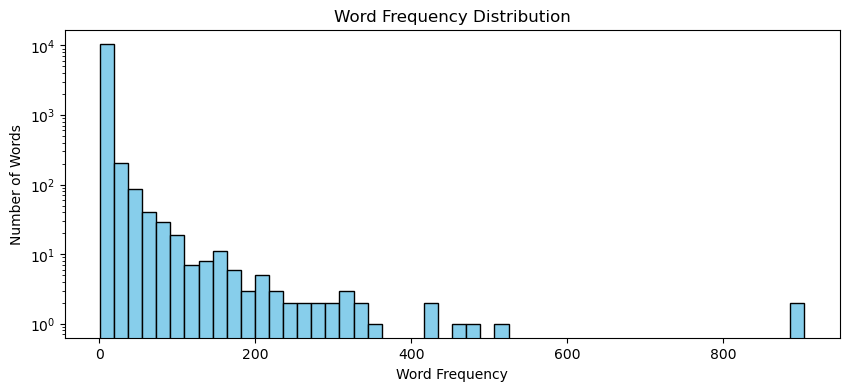

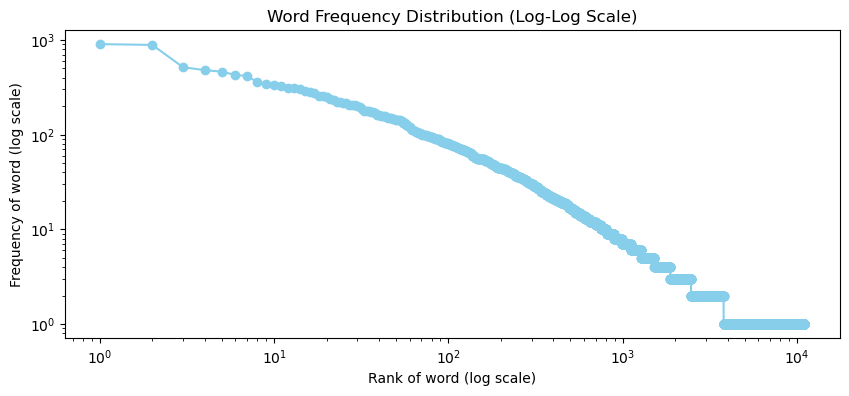

In [28]:


# Assuming word_freq_df is your DataFrame with the word frequencies

# Histogram of word frequencies
plt.figure(figsize=(10, 4))
plt.hist(word_freq_df['Frequency'], bins=50, color='skyblue', edgecolor='black')
plt.title('Word Frequency Distribution')
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words')
plt.yscale('log')  # Use log scale for better visibility of lower frequencies
plt.show()

# Log-log plot
plt.figure(figsize=(10, 4))
plt.loglog(range(1, len(word_freq_df) + 1), word_freq_df['Frequency'].sort_values(ascending=False), marker='o', linestyle='-', color='skyblue')
plt.title('Word Frequency Distribution (Log-Log Scale)')
plt.xlabel('Rank of word (log scale)')
plt.ylabel('Frequency of word (log scale)')
plt.show()

### Frequent Words - Where do we place the cut-off

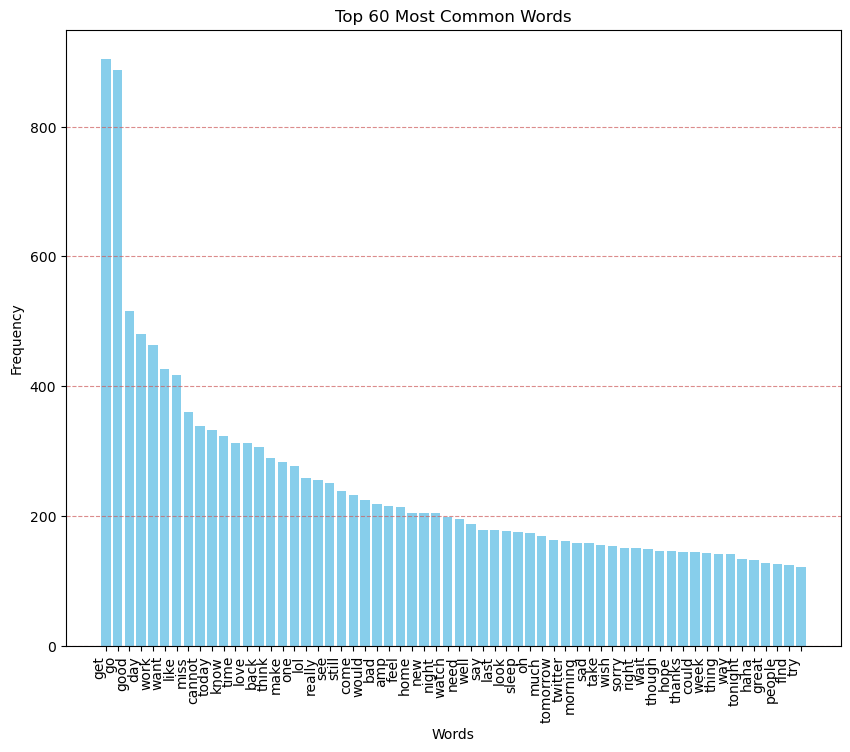

In [29]:


# Visualize the top 20 most common words
top_n = 60
plt.figure(figsize=(10, 8))
plt.bar(word_freq_df['Word'][:top_n], word_freq_df['Frequency'][:top_n], color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90, ha='right')
plt.title(f'Top {top_n} Most Common Words')
plt.grid(axis='y', linestyle='--', alpha=0.7, color='indianred')
plt.show()


In [30]:
high_freq_words = word_freq_df[word_freq_df['Frequency'] > 10000]['Word']
', '.join(high_freq_words), high_freq_words.shape

('', (0,))

In [31]:
word_freq_df.describe()

,Frequency
count,11024.000000
mean,4.900762
std,22.996770
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,904.000000


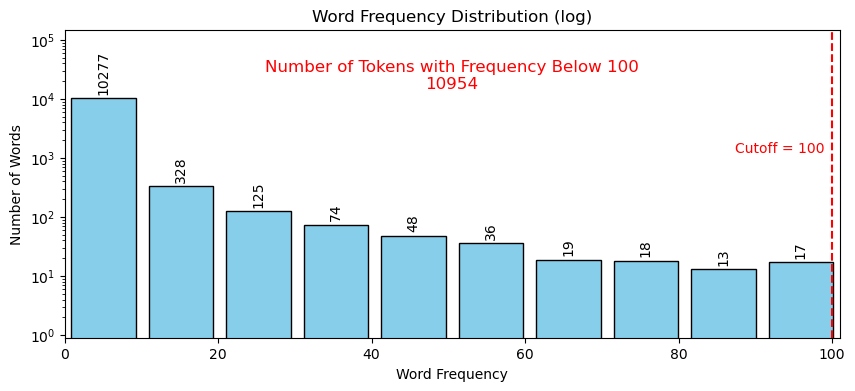

In [32]:


# Assuming you have data, bins, and other settings from the previous example
data = word_freq_df['Frequency']
bins = 10
x_line = 100  # Example cutoff value, adjust as needed
x_max = x_line +1  # Assuming x_max is defined
hist, bin_edges = np.histogram(data, bins=bins, range=(0, x_max))

fig, ax = plt.subplots(figsize=(10, 4))
width_scaling_factor = 0.8
for i in range(len(hist)):
    height = hist[i]
    center = (bin_edges[i] + bin_edges[i+1]) / 2
    original_width = bin_edges[i+1] - bin_edges[i]
    adjusted_width = original_width * width_scaling_factor+0.3
    
    ax.bar(center, height, align='center', width=adjusted_width, color='skyblue', edgecolor='black')
    if height > 0:
        ax.annotate(f'{height}', xy=(center, height), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom', rotation=90)

ax.set_title('Word Frequency Distribution (log)')
ax.set_xlabel('Word Frequency')
ax.set_ylabel('Number of Words')
ax.set_yscale('log')
ax.axvline(x=x_line, color='red', linestyle='--')

# Add label to the red line
ax.text(x_line-1, ax.get_ylim()[1]*0.1, f'Cutoff = {x_line}', color='red', ha='right', va='center')

below_x = len(word_freq_df[word_freq_df['Frequency'] < x_line])

ax.text(0.5, 0.8,
        f'Number of Tokens with Frequency Below {x_line}\n{below_x}',
        color='red', fontsize=12, ha='center', va='bottom', transform=plt.gca().transAxes)
ax.margins(0.05, 0.4)
ax.set_xlim(0, x_max)

plt.show()

In [34]:
tokenized

,text,target
0,"['know', 'go', 'soon', 'possible', 'like', 'ge...",0
1,"['lose', 'sad', 'us', 'love']",0
2,"['would', 'wifed', 'would']",0
3,"['carita', 'san', 'antonio', 'need', 'someone'...",0
4,"['sorry', 'prepare', 'emotionally', 'case', 'b...",0
...,...,...
7962,"['phone', 'wrosie', 'summer']",1
7963,"['see', 'many', 'thing', 'write', 'much', 'tru...",1
7964,"['sympathize', 'straighten', 'hair', 'everyday']",1
7965,"['wonderful', 'day', 'family', 'get', 'stuff',...",1


In [35]:
tokenized['text'] = tokenized['text'].apply(ast.literal_eval)
tokenized['text'] = tokenized['text'].apply(lambda x: ' '.join(x))

In [36]:
tokenized


,text,target
0,know go soon possible like get back home want ...,0
1,lose sad us love,0
2,would wifed would,0
3,carita san antonio need someone rough,0
4,sorry prepare emotionally case basket case happen,0
...,...,...
7962,phone wrosie summer,1
7963,see many thing write much true wise man,1
7964,sympathize straighten hair everyday,1
7965,wonderful day family get stuff great dinner ti...,1


In [37]:


vectorizer = TfidfVectorizer(max_features=1000,
                             max_df=30000, 
                             min_df=20, 
                             ngram_range=(1,2))

tfidf_matrix = vectorizer.fit_transform(tokenized['text'])

In [38]:
feature_names = vectorizer.get_feature_names_out()
tfidf_pd = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

In [39]:
tfidf_pd

,able,actually,add,ago,ah,ahhh,air,almost,alone,already,...,wrong,xx,xxx,ya,yay,yeah,year,yes,yesterday,yet
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
tfidf_pd.to_csv('tfidf_pd.csv')


### SVDTransformer for dimentionality reduction

In [44]:
tfidf_pd = pd.read_csv('tfidf_pd.csv')

In [45]:


svd = decomposition.TruncatedSVD(n_components=200)
svd_df = svd.fit_transform(tfidf_pd)

In [46]:
svd_df_pd = pd.DataFrame(svd_df, columns=[f'PC{i+1}' for i in range(svd_df.shape[1])])
svd_df_pd

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC191,PC192,PC193,PC194,PC195,PC196,PC197,PC198,PC199,PC200
0,0.000007,0.407900,-0.104358,-0.005987,-0.179310,0.142485,0.129723,0.065996,0.206474,0.018296,...,0.002387,-0.011510,-0.007990,0.010060,0.010906,0.002899,0.011953,0.007829,-0.007365,0.021489
1,1.000003,-0.001765,0.036647,0.002678,-0.005465,0.001387,0.032933,0.013677,-0.074752,0.351154,...,0.011122,0.025759,0.015156,0.018378,-0.001021,0.016545,-0.019269,-0.042749,0.000214,-0.001213
2,2.000002,0.005129,-0.014028,0.004993,-0.018433,0.007066,0.022403,0.066966,0.090184,0.029892,...,-0.002522,0.008562,-0.014520,0.004693,0.002516,-0.019911,0.011107,0.006456,0.009240,-0.005248
3,3.000002,0.017032,-0.003175,0.011709,-0.012394,0.008475,0.005761,0.022043,0.010434,-0.004799,...,-0.020517,0.018686,-0.049685,-0.010120,-0.039210,-0.016612,0.053974,0.001129,0.032985,-0.091973
4,4.000001,0.014475,0.017740,0.006969,-0.019555,-0.000745,0.010372,0.025135,0.015652,-0.006815,...,0.033103,-0.017758,0.009735,0.013065,-0.006917,0.003257,-0.014039,0.013585,-0.030592,0.016699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7962,7961.999999,-0.100423,-0.009852,-0.029453,-0.014486,0.024555,-0.032186,-0.040360,-0.023676,-0.021055,...,-0.075732,-0.009694,-0.001652,0.006264,0.007626,0.004855,-0.020355,0.010717,0.007603,0.047809
7963,7963.000001,-0.072723,0.010542,-0.011581,-0.037478,0.019368,-0.013179,-0.024920,-0.030587,-0.015083,...,0.028003,-0.039101,-0.072542,-0.060780,0.026536,0.020149,-0.032741,0.015929,0.050486,0.064778
7964,7963.999999,-0.105595,-0.002766,-0.031959,-0.000966,0.004353,-0.038433,-0.027113,-0.012924,-0.027059,...,0.285179,0.127325,0.021167,-0.060799,-0.132284,0.001280,-0.003633,0.158029,-0.246302,-0.003306
7965,7965.000003,0.071016,-0.023717,0.169930,0.017023,-0.125516,0.046760,-0.163505,-0.010296,0.016035,...,-0.046039,-0.010629,-0.084342,0.004238,0.144770,0.028841,0.028823,0.040680,-0.073517,-0.018905


In [47]:
svd_df_pd.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       ...
       'PC191', 'PC192', 'PC193', 'PC194', 'PC195', 'PC196', 'PC197', 'PC198',
       'PC199', 'PC200'],
      dtype='object', length=200)

In [48]:
svd_df_pd.to_csv('svd_df.csv')